In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os, glob, warnings
import re
import tarfile
from ipywidgets import Image
from IPython.display import display, Image
from astropy.stats import sigma_clip
from colorama import Fore
import matplotlib.cm as cm
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table
from scipy import stats

warnings.filterwarnings("ignore")
sb.set(style="ticks", color_codes=True, context="notebook", font_scale=1.4)
sb.set_style({"xtick.direction": "in","ytick.direction": "in"})

mainpath = '/Users/jorgetil/Astro/HITS'

In [154]:
var_gal = pd.read_csv('%s/tables/galaxy/%s_feat_SDSS_galaxy_psfmatch_variable_cand_GalaxyZoo.csv.gz'
                  % (mainpath, year), compression='gzip')
var_gal.set_index('internalID', inplace=True)
print var_gal.shape

(430, 100)


In [155]:
print var_gal.columns.values

['raMedian' 'decMedian' 'Amplitude' 'AndersonDarling' 'Autocor_length'
 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'CAR_tau' 'ChiSqProb' 'Con' 'Eta_e'
 'ExcessVariance' 'ExcessVariance_e' 'FluxPercentileRatioMid20'
 'FluxPercentileRatioMid35' 'FluxPercentileRatioMid50'
 'FluxPercentileRatioMid65' 'FluxPercentileRatioMid80' 'Gskew'
 'LinearTrend' 'MaxSlope' 'Mean' 'Meanvariance' 'MedianAbsDev' 'MedianBRP'
 'MedianErr' 'Nout2sigma' 'PairSlopeTrend' 'PercentAmplitude'
 'PercentDifferenceFluxPercentile' 'PeriodLS' 'Period_fit' 'Psi_CS'
 'Psi_eta' 'Q31' 'RatioMaxMinFlux' 'Rcs' 'Skew' 'SlottedA_length'
 'SmallKurtosis' 'Std' 'StdToErr' 'StetsonK' 'StetsonK_AC' 'RAdeg' 'DEdeg'
 'errHalfMaj' 'errHalfMin' 'errPosAng' 'objID' 'mode' 'q_mode' 'class'
 'SDSS12' 'm_SDSS12' 'flags' 'ObsDate' 'Q' 'umag' 'e_umag' 'gmag' 'e_gmag'
 'rmag' 'e_rmag' 'imag' 'e_imag' 'zmag' 'e_zmag' 'zsp' 'e_zsp' 'f_zsp'
 'zph' 'e_zph' 'avg_zph' 'pmRA' 'e_pmRA' 'pmDE' 'e_pmDE' 'SpObjID'
 'spType' 'spCl' 'subClass' 'ExcessVariance_

In [156]:
var_gal['GZ_morph'] = 'ND'
var_gal.GZ_morph[var_gal.SPIRAL == 1] = 'S'
var_gal.GZ_morph[var_gal.ELLIPTICAL == 1] = 'E'
var_gal.GZ_morph[var_gal.UNCERTAIN == 1] = 'uncertain'
var_gal = var_gal[var_gal.spCl != 'QSO']

In [157]:
var_gal.to_csv('%s/tables/galaxy/%s_feat_SDSS_galaxy_psfmatch_variable_cand_GalaxyZoo.csv.gz'
                  % (mainpath, year), compression='gzip')

In [96]:
print var_gal.spCl.value_counts()
print var_gal.GZ_morph.value_counts()

GALAXY    484
Name: spCl, dtype: int64
uncertain    246
S            187
ND            29
E             22
Name: GZ_morph, dtype: int64


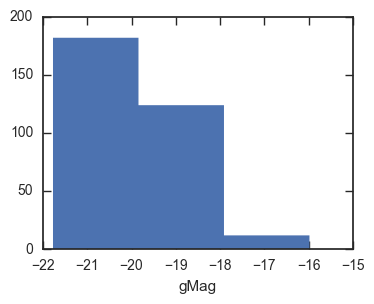

[-30, -20, -18, -10]


In [124]:
plt.figure(figsize=(4,3))
plt.hist(var_gal.gMag, bins=3, histtype='stepfilled', color='b', lw=0)
plt.xlabel('gMag')
plt.show()
brg_bins = np.histogram(var_gal.gMag, bins=3)[1]
brg_bins = [-30, -20, -18, -10]
z_bins = [0, 0.07, 0.14, 0.3]
print brg_bins

In [146]:
to_follow = []
for k in range(3):
    print 'bin    : ', [brg_bins[k], brg_bins[k+1]]
    aux = var_gal.query('gMag > %f and gMag < %f and gmag < 17.75' %
                            (brg_bins[k], brg_bins[k+1]))
    print 'sources: ',len(ids_btw)
    print aux.GZ_morph.value_counts()
    
    #plt.figure(figsize=(3,2))
    #plt.hist(aux.zsp, bins=5, histtype='stepfilled')
    #plt.xlabel('z')
    #plt.show()
    
    aux_e = aux.query('GZ_morph == "E"')
    aux_s = aux.query('GZ_morph == "S"')
    to_follow.append(aux_e.nlargest(4, columns='ExcessVariance_cor'))
    to_follow.append(aux_s.nlargest(4, columns='ExcessVariance_cor'))
    nn = len(to_follow[-1]) + len(to_follow[-2])
    
    if nn < 10:
        extra = aux.query('GZ_morph == "uncertain" or GZ_morph == "ND"')
        to_follow.append(extra.nlargest(4 - nn, columns='ExcessVariance_cor'))

print '________________________________________'
to_follow = pd.concat(to_follow, axis=0)
print to_follow.shape
print to_follow.GZ_morph.value_counts()

bin    :  [-30, -20]
sources:  11
S            37
uncertain    28
E             7
ND            7
Name: GZ_morph, dtype: int64
bin    :  [-20, -18]
sources:  11
S            32
uncertain    25
E             5
ND            1
Name: GZ_morph, dtype: int64
bin    :  [-18, -10]
sources:  11
uncertain    5
ND           3
S            2
E            1
Name: GZ_morph, dtype: int64
________________________________________
(20, 101)
S            10
E             9
uncertain     1
Name: GZ_morph, dtype: int64


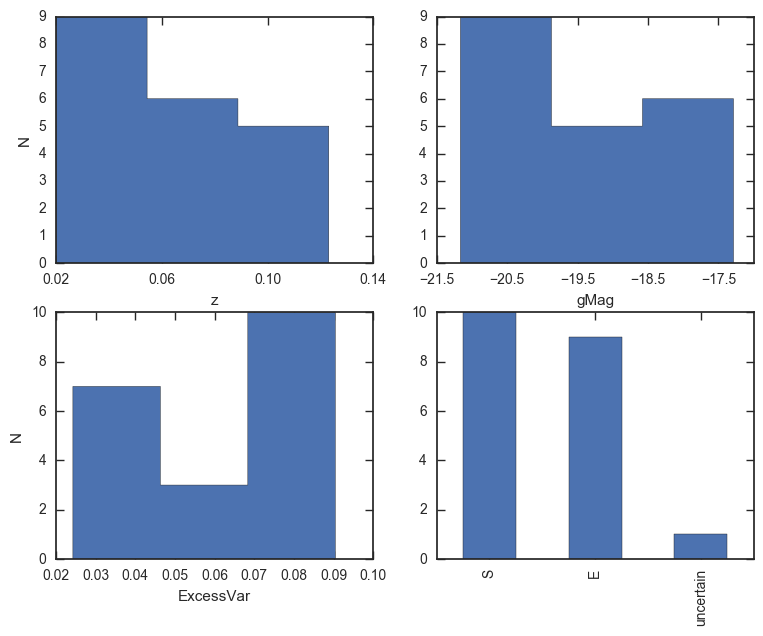

In [152]:
fig, ax = plt.subplots(ncols=2, nrows=2,figsize = (9,7))

ax[0,0].hist(to_follow.zsp, bins=3, histtype='stepfilled')
ax[0,0].set_ylabel('N')
ax[0,0].set_xlabel('z')
ax[0,0].set_xticks(ax[0,0].get_xticks()[::2])

ax[0,1].hist(to_follow.gMag, bins=3, histtype='stepfilled')
ax[0,1].set_xlabel('gMag')
ax[0,1].set_xticks(ax[0,1].get_xticks()[::2])

ax[1,0].hist(to_follow.Amplitude, bins=3, histtype='stepfilled')
ax[1,0].set_xlabel('ExcessVar')
ax[1,0].set_ylabel('N')

ax[1,1] = to_follow.GZ_morph.value_counts().plot.bar()

plt.show()

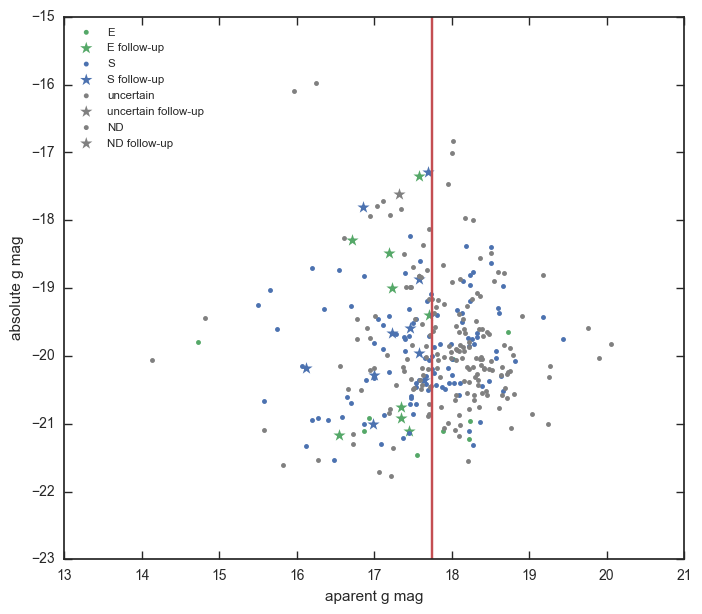

In [153]:
#mask = (abs_mag > -24) & (abs_mag < -13)
c = ['g','b','grey','grey']
plt.figure(figsize=(8,7))
for k, tipo in enumerate(set(var_gal.GZ_morph)):
    plot = var_gal.query('GZ_morph == "%s"' % tipo)
    plot_s = to_follow.query('GZ_morph == "%s"' % tipo)
    if tipo in ['ND', 'uncertain']:
        plt.scatter(plot.gmag, plot.gMag, color=c[k],
                    marker='.', s=50, lw=0, alpha=1,
                    label=tipo)
        plt.scatter(plot_s.gmag, plot_s.gMag, color=c[k],
                    marker='*', s=85, lw=0, alpha=1,
                    label='%s follow-up' % tipo)
    else:
        plt.scatter(plot.gmag, plot.gMag, color=c[k],
                    marker='.', s=50, lw=0, alpha=1,
                    label=tipo)
        plt.scatter(plot_s.gmag, plot_s.gMag, color=c[k],
                    marker='*', s=85, lw=0, alpha=1,
                    label='%s follow-up' % tipo)
plt.axvline(17.75, color='r')
plt.legend(loc='upper left', fontsize='x-small')
plt.xlabel('aparent g mag')
plt.ylabel('absolute g mag')
plt.show()

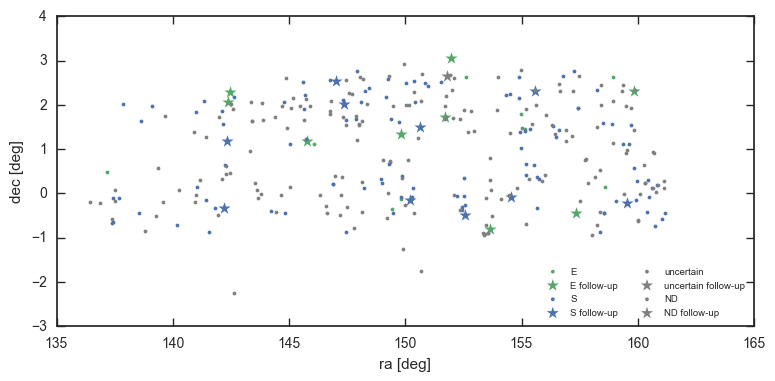

,raMedian,decMedian,gmag,GZ_morph
internalID,,,,
Blind15A_14_N5_0246_2484,142.186664,-0.320946,17.689,S
Blind15A_15_N20_0249_1729,142.352217,1.186302,16.990,S
Blind15A_15_S14_1648_3948,142.359294,2.070728,17.583,E
Blind15A_15_S20_1032_3376,142.473114,2.280386,16.711,E
Blind15A_16_N24_0245_0193,145.793346,1.185624,17.710,E
Blind15A_25_S15_1541_0529,147.041098,2.539338,16.849,S
Blind15A_25_N3_1755_2954,147.373563,2.029623,17.232,S
Blind15A_26_N29_0690_2344,149.829314,1.333523,17.342,E
Blind15A_27_N12_1773_2648,150.208354,-0.149130,16.118,S


In [154]:
c = ['g','b','grey','grey']
plt.figure(figsize=(9,4))
for k, tipo in enumerate(set(var_gal.GZ_morph)):
    plot = var_gal.query('GZ_morph == "%s"' % tipo)
    plot_s = to_follow.query('GZ_morph == "%s"' % tipo)
    if tipo in ['ND', 'uncertain']:
        plt.scatter(plot.raMedian, plot.decMedian, color=c[k],
                    marker='.', s=30, lw=0, alpha=1,
                    label=tipo)
        plt.scatter(plot_s.raMedian, plot_s.decMedian, color=c[k],
                    marker='*', s=85, lw=0, alpha=1,
                    label='%s follow-up' % tipo)
    else:
        plt.scatter(plot.raMedian, plot.decMedian, color=c[k],
                    marker='.', s=30, lw=0, alpha=1,
                    label=tipo)
        plt.scatter(plot_s.raMedian, plot_s.decMedian, color=c[k],
                    marker='*', s=85, lw=0, alpha=1,
                    label='%s follow-up' % tipo)
plt.legend(loc='lower right', fontsize='xx-small', ncol=2)
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.show()
to_follow.query('gmag < 17.75')[['raMedian', 'decMedian', 'gmag', 'GZ_morph']].sort_values('raMedian')